# Parameterization for sediment released by sea-ice

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
import glob
import datetime as dt
import pickle
import scipy.ndimage as ndimage

%matplotlib notebook

##### Parameters

In [3]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800

In [4]:
N = 256
vals_cont = np.ones((N, 4))
vals_cont[:, 0] = np.linspace(117/N, 1, N)
vals_cont[:, 1] = np.linspace(82/N, 1, N)
vals_cont[:, 2] = np.linspace(60/N, 1, N)
sed_cmap = matplotlib.colors.ListedColormap(vals_cont).reversed()

##### Load files

In [5]:
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask     = np.array(mask.variables['tmask'])
land_mask = np.ma.masked_where((tmask[0,:,:,:] > 0.1), tmask[0,:,:,:])

mesh     = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
mesh_lon = np.array(mesh.variables['nav_lon'])
mesh_lat = np.array(mesh.variables['nav_lat'])

##### Functions:

In [6]:
def load_tracks(filename):
    nemo_file  = nc.Dataset(filename)

    traj = np.array(nemo_file.variables['trajectory']) # dimensions: number of particles, tracks
    time = np.array(nemo_file.variables['time'])       # units: seconds
    lat  = np.array(nemo_file.variables['lat'])        # degrees North
    lon  = np.array(nemo_file.variables['lon'])        # degrees East

    return traj, time, lon, lat

In [7]:
def check_laptev(CB_traj, CB_lon, CB_lat, CB_time):
    # does the parcel spend time in the laptev sea in the fall?

    # Define boundary latitudes and longitudes for the Laptev Sea region
    trajS_bdy1 = 68;     trajN_bdy1 = 74;
    trajE_bdy1 = -170;   trajW_bdy1 = -210;

    trajS_bdy2 = 70;     trajN_bdy2 = 75;
    trajE_bdy2 = -185;   trajW_bdy2 = -230;
    
    Laptev_particle = False
    # At each time step:
    for timestep in range(0,len(CB_traj)):
        if ((CB_lon[timestep]   < trajE_bdy1) & (CB_lon[timestep] > trajW_bdy1) \
            & (CB_lat[timestep] < trajN_bdy1) & (CB_lat[timestep] > trajS_bdy1)) or \
           ((CB_lon[timestep]   < trajE_bdy2) & (CB_lon[timestep] > trajW_bdy2) \
            & (CB_lat[timestep] < trajN_bdy2) & (CB_lat[timestep] > trajS_bdy2)):

            start_time   = dt.datetime(2015,12,31) - dt.timedelta(seconds=CB_time[0])
            current_time = start_time - dt.timedelta(seconds=CB_time[timestep])

            # And is the parcel on the shelf in the fall?
            if current_time.month in [9,10,11,12]:
                Laptev_particle = True
                break
                    
    return Laptev_particle

In [8]:
def parcel_origin(CB_lon, CB_lat, CB_time, CB_traj):

    dim_parc = int((CB_lon.shape[0]/12)/np.ceil(CB_lon.shape[1]/(4*365))) # bottom converts 6 hour to days    
    dim_time = int(12*((CB_lon.shape[0]/dim_parc)/12))

    particles_origin = np.zeros((dim_parc,dim_time))
    # --- Russian shelf in fall = 1
    # --- else = 0

    for release_time in range(0,dim_time):
        for location in range(0,dim_parc):
            ind = location + release_time*dim_parc
            lon_loc = CB_lon[ind,:]
            lat_loc = CB_lat[ind,:]
            time_loc = CB_time[ind,:]
            traj_loc = CB_traj[ind,:]

            Laptev_particle = check_laptev(traj_loc, lon_loc, lat_loc, time_loc)

            if Laptev_particle:
                particles_origin[location, release_time] = 1

    return particles_origin

In [9]:
def interp_np(nav_lon, nav_lat, var_in, lon_ANHA12, lat_ANHA12):
    ''' Interpolate some field to ANHA12 grid.
        The function is based on the bilinear interpolation in scipy, griddata 
        =======================================================================
            nav_lon, nav_lat        : input field lon/lat
            lon_ANHA12, lat_ANHA12  : ANHA12 defined lons/lats
            var_in                  : 2-D model variable
    '''
    from scipy.interpolate import griddata
    LatLonPair = (nav_lon, nav_lat)
    var_out = griddata(LatLonPair, var_in, (lon_ANHA12, lat_ANHA12), method='cubic')
    # Take nearest neighbour interpolation to fill nans
    var_fill = griddata(LatLonPair, var_in, (lon_ANHA12, lat_ANHA12), method='nearest')
    
    # fill nans with constant value (0.1)
    var_out[np.isnan(var_out)] = var_fill[np.isnan(var_out)]
    return var_out

Parameterization components:

1) Ice melt:
    - if (ice production < 0) --> ice is melting 
    - units of ice melt, iiceprod, are in m/kt (180 s timestep)
        - convert m/kt to m/s
        - multiply iiceprod by the grid box area to get a volume of melt
2) Sediment forcing
    - sediment content forcing field: units of grams of sediment / m3 of ice
        - background sediment content amount (include higher on shelf regions)
        - Laptev Sea sediment amounts
    - multiply forcing field by sediment content 
    - multiply sediment forcing field by ice melt (m3) to get grams of sediment
    - add sediment to surface grid box + solubility, Mn content

### (2) Sediment forcing field

Load parcel trajectories

In [10]:
CB_traj, CB_time, CB_lon, CB_lat = load_tracks('/ocean/brogalla/GEOTRACES/parcels/trials/'+\
                                               'Particles_CB-20200205-extended-region2.nc')

In [11]:
particles_origin = parcel_origin(CB_lon, CB_lat, CB_time, CB_traj)

In [12]:
dim_parc = int((CB_lon.shape[0]/12)/np.ceil(CB_lon.shape[1]/(4*365)))
dim_lons = len(set(CB_lon[0:dim_parc,0]))

proportion_laptev = np.empty(CB_lon[0:dim_parc,0].shape)

for location in range(0,dim_parc):
    proportion_laptev[location] = np.sum(particles_origin[location,:])/particles_origin.shape[1]

In [13]:
parcel_lons = CB_lon[0:186, 0]
parcel_lats = CB_lat[0:186, 0]

Forcing field dimensions

In [14]:
forcing_lons = mesh_lon[:,:]
forcing_lats = mesh_lat[:,:]
forcing_sed  = np.zeros(forcing_lons.shape)

Interpolate Canada Basin proportions:

In [15]:
forcing_sed = interp_np(parcel_lons, parcel_lats, proportion_laptev, forcing_lons, forcing_lats)

In [32]:
# North of Nares Strait
forcing_sed[(forcing_lons < -50) & (forcing_lons > -70) & (forcing_lats > 78)] = 0.05
forcing_sed[(forcing_lons > -100) & (forcing_lats > 72)  & (forcing_lats < 80)] = 0.01
forcing_sed[(forcing_lons < -75) & (forcing_lons > -80) & (forcing_lats > 81) & (forcing_lats < 83.5)] = 0.05
forcing_sed[(forcing_lons < -85) & (forcing_lons > -100) & (forcing_lats > 80) & (forcing_lats < 82.5)] = 0.03
forcing_sed[(forcing_lons < -65) & (forcing_lons > -93) & (forcing_lats > 78) & (forcing_lats < 83)] = 0.03

# Western CAA low background values
# forcing_sed[(forcing_lons < -70) & (forcing_lons > -128) & (forcing_lats < 74)] = 0.02
# forcing_sed[(forcing_lons < -100) & (forcing_lons > -128)  & (forcing_lats < 79) & (forcing_lats > 74)] = 0.02
# forcing_sed[(forcing_lons < -120) & (forcing_lons > -135)  & (forcing_lats < 76) & (forcing_lats > 72)] = 0.05
# CAA background rate
forcing_sed[(forcing_lons >-128) & (forcing_lons < -79) & (forcing_lats < 79) & (forcing_lats > 60)] = 0.015
forcing_sed[(forcing_lons >-78) & (forcing_lons < -70) & (forcing_lats < 73) & (forcing_lats > 63)] = 0.00

# Beaufort Shelf
forcing_sed[(forcing_lons <-128) & (forcing_lats < 71.3) & (forcing_lats > 68)] = 0.01

In [33]:
Z2 = ndimage.gaussian_filter(forcing_sed, sigma=16, order=0)

In [34]:
# Zero the forcing field outside of the domain:
Z2[0:imin, :]  = 0
Z2[imax:-1, :] = 0
Z2[:, 0:jmin]  = 0
Z2[:, jmax:-1] = 0

<IPython.core.display.Javascript object>


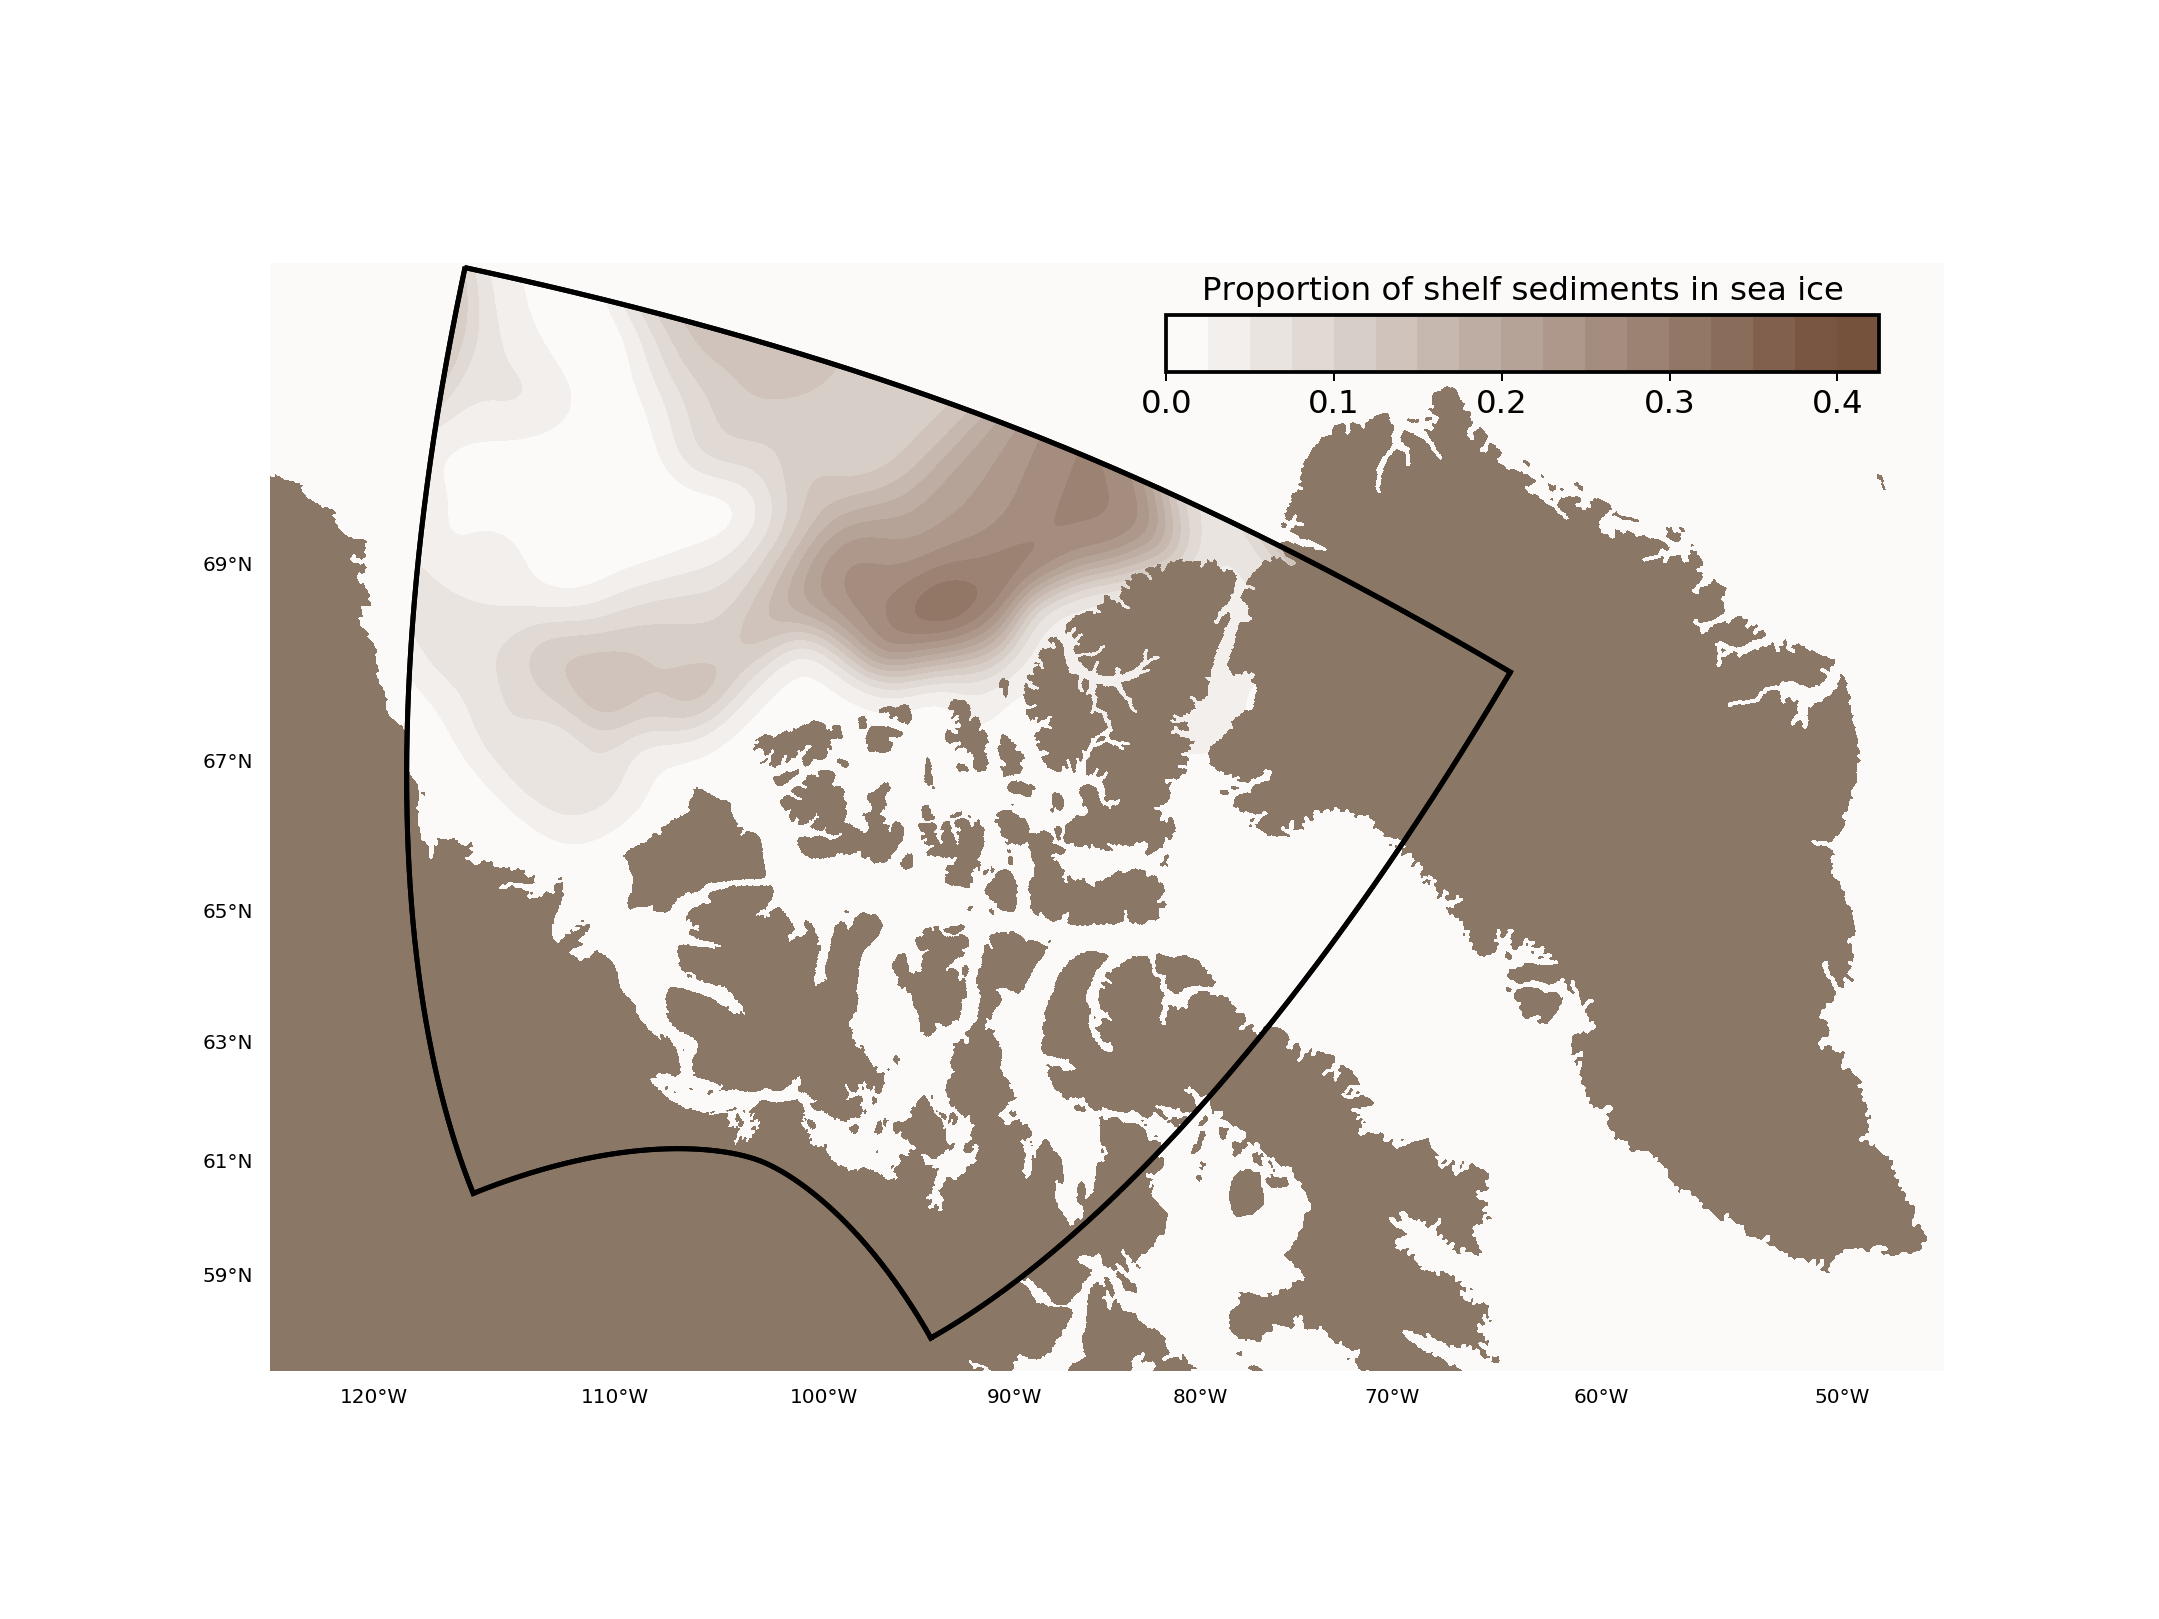

Text(0.5, 1.0, 'Proportion of shelf sediments in sea ice')

In [35]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))

x_model, y_model = proj1(forcing_lons, forcing_lats)
CS1 = proj1.contourf(x_model, y_model, Z2, vmin=0.0, vmax=0.4, levels=np.arange(0,0.45,0.025), cmap=sed_cmap)

x_sub, y_sub = proj1(mesh_lon, mesh_lat)
proj1.plot(x_sub[1480:2180,800],   y_sub[1480:2180,800],   'k-', lw=2.0,zorder=5)
proj1.plot(x_sub[1480:2180,800].T, y_sub[1480:2180,800].T, 'k-', lw=2.0,zorder=5)
proj1.plot(x_sub[1480:2180,160],   y_sub[1480:2180,160],   'k-', lw=2.0,zorder=5)
proj1.plot(x_sub[1480:2180,160].T, y_sub[1480:2180,160].T, 'k-', lw=2.0,zorder=5)
proj1.plot(x_sub[1480,160:800],    y_sub[1480,160:800],    'k-', lw=2.0,zorder=5)
proj1.plot(x_sub[1480,160:800].T,  y_sub[1480,160:800].T,  'k-', lw=2.0,zorder=5)
proj1.plot(x_sub[2180,160:800],    y_sub[2180,160:800],    'k-', lw=2.0,zorder=5)
proj1.plot(x_sub[2180,160:800].T,  y_sub[2180,160:800].T,  'k-', lw=2.0,zorder=5)

# cbaxes1 = fig.add_axes([0.74, 0.20, 0.04, 0.35]) 
cbaxes1 = fig.add_axes([0.54, 0.77, 0.33, 0.035]) 
CB1 = plt.colorbar(CS1, cax=cbaxes1, orientation='horizontal', ticks=np.arange(0,1.1,0.1))
CB1.ax.tick_params(labelsize=13)
CB1.outline.set_linewidth(1.5)
CB1.ax.set_title('Proportion of shelf sediments in sea ice', fontsize=13)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/forcing-sediments-ice.png', bbox_inches='tight', dpi=300)

In [74]:
x_ind = np.arange(1590, 2100, 1)
y_ind = (-7/8)*x_ind + 1487.5 + 700

CB_indx = []
CB_indy = []

for index in range(0,len(x_ind)):
    CB_x = np.arange(x_ind[index],2180,1)
    CB_y = np.ones(CB_x.shape)*y_ind[index]
    
    CB_indx = np.append(CB_x, CB_indx)
    CB_indy = np.append(CB_y, CB_indy)

In [75]:
Z_CB = [Z2[int(i),int(j)] for i,j in zip(CB_indx, CB_indy)]

In [76]:
print('Maximum sediment content:', np.amax(Z_CB)*1000*0.5)
print('Minimum sediment content:', np.amin(Z_CB)*1000*0.5)
print('Average sediment content:', np.average(Z_CB)*1000*0.5)

Maximum sediment content: 157.16317789771753
Minimum sediment content: 0.3564441094219177
Average sediment content: 48.26138351978607


save to forcing field:

In [37]:
c   = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12-EXH006_y2015m01d05_gridT.nc','r')

ncd = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ice_sediment-20201215-tuning3.nc', 'w', zlib=True)
ncd.createDimension('x',len(c.dimensions['x']))
ncd.createDimension('y',len(c.dimensions['y']))

# variables
nav_lat = ncd.createVariable('nav_lat', 'float32', ('y','x'))
nav_lat.long_name = 'Latitude'
nav_lat.units = 'degrees_north'
nav_lat[:] = mesh_lat

nav_lon = ncd.createVariable('nav_lon', 'float32', ('y','x'))
nav_lon.long_name = 'Longitude'
nav_lon.units = 'degrees_east'
nav_lon[:] = mesh_lon

mn_sed = ncd.createVariable('prop_shelf', 'float32', ('y','x'))
mn_sed.units = 'none'
mn_sed.long_name = 'Proportion of shelf sediments in ice'  
mn_sed.coordinates = 'nav_lon nav_lat'
mn_sed[:] = Z2

ncd.close()

Compare

In [25]:
old = nc.Dataset('/ocean/brogalla/GEOTRACES/data/paper1-forcing-files/ice_sediment-20200428.nc')
new = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ice_sediment-20201119.nc')

In [26]:
sed_old = np.array(old.variables['prop_shelf'])
sed_new = np.array(new.variables['prop_shelf'])

In [27]:
np.array_equal(sed_old, sed_new)

True